In [1]:
import torch
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import os

/home/shaunak/.virtualenvs/llm_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config dataset path.
model_path = "distilbert/distilgpt2"
data_path = r"../data/processed_data/train.json"
output_path = r"../output"

# force to use GPU.
assert torch.cuda.is_available(), "Use GPU!"
device = torch.device("cuda")

In [3]:
# Implement a custom callback to record the change of loss value
# in real time during model training.
class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.losses.append(logs["loss"])

In [4]:
def process_data(tokenizer):
    dataset = load_dataset("json", data_files=data_path, split="train[:1500]")
    print(dataset)

    def format_example(example):
        instruction = f"Question: {example['Question']}\nAnalysis: {example['Complex_CoT']}"
        inputs = tokenizer(
            f"{instruction}\n### Answer: \n{example['Response']}<|endoftext|>",
            padding="max_length",
            truncation=True,
            
            max_length=512,
            return_tensors="pt"
        )
        return {"input_ids": inputs["input_ids"].squeeze(0), "attention_mask": inputs["attention_mask"].squeeze(0)}

    return dataset.map(format_example, remove_columns=dataset.column_names)

In [5]:
# LoRA configuration.
# r means the rank of the low-rank decomposition.
# lora_alpha is the scaling factor.
# target_modules are the modules to be decomposed.
# lora_dropout is the dropout rate.
# task_type is the task type -- Causal Language Model.
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
# Training arguments.
training_args = TrainingArguments(
    output_dir=output_path,
    per_device_train_batch_size=2,  # storage limited.
    gradient_accumulation_steps=4,  # accumulate gradient, batch_size=8
    num_train_epochs=500,
    learning_rate=3e-4,
    fp16=True,  # open fp16, accelerate training.
    logging_steps=20,
    save_strategy="no",
    report_to="none",
    optim="adamw_torch",
    no_cuda=False,
    dataloader_pin_memory=False,  # use pinned memory to accelerate training.
    remove_unused_columns=False  # prevent error.
)

/home/shaunak/.virtualenvs/llm_project/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 811,008 || all params: 82,723,584 || trainable%: 0.9804
Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 1500
})


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Start training...


/home/shaunak/.virtualenvs/llm_project/lib/python3.10/site-packages/transformers/pytorch_utils.py:122: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
20,5.138600
40,0.881400
60,0.684800
80,0.535800
100,0.412700
120,0.341900
140,0.338300
160,0.356300
180,0.301100
200,0.306600


Model saved to ../output
Loss curve saved to loss_curve.png


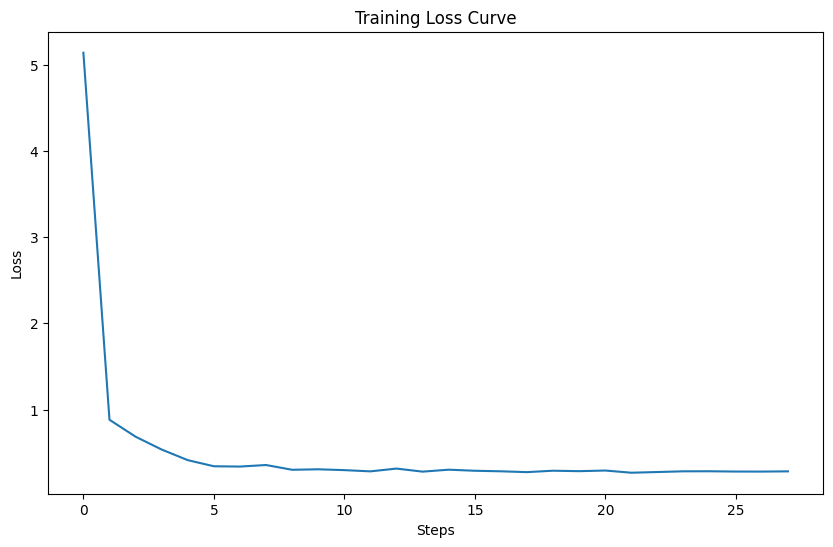

In [7]:
def main():
    # create output path.
    os.makedirs(output_path, exist_ok=True)

    # load tokenizer.
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token

    # load model.
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

    # preprocess data.
    dataset = process_data(tokenizer)

    # loss callback.
    loss_callback = LossCallback()

    # data collator.
    def data_collator(data):
        batch = {
            "input_ids": torch.stack([torch.tensor(d["input_ids"]) for d in data]).to(device),
            "attention_mask": torch.stack([torch.tensor(d["attention_mask"]) for d in data]).to(device),
            # use input_ids as labels.
            "labels": torch.stack([torch.tensor(d["input_ids"]) for d in data]).to(device)
        }
        return batch

    # create trainer.
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        data_collator=data_collator,
        callbacks=[loss_callback]
    )

    # start training.
    print("Start training...")
    trainer.train()

    # save model.
    trainer.model.save_pretrained(output_path)
    print(f"Model saved to {output_path}")

    # plot loss curve.
    plt.figure(figsize=(10, 6))
    plt.plot(loss_callback.losses)
    plt.title("Training Loss Curve")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.savefig(os.path.join(output_path, "loss_curve.png"))
    print("Loss curve saved to loss_curve.png")

if __name__ == "__main__":
    main()